In [1]:
import numpy as np
import torch
from scipy import optimize
from sim.cartpole_dc import CartPoleEnv
import csv
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.single.local_best import LocalBestPSO
from matplotlib import pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
import tikzplotlib
from util.io import read_data

In [3]:
states, actions = read_data('data.csv')
states = torch.tensor(states).detach()
actions = - torch.tensor(actions).detach()
print(states.shape, actions.shape)

torch.Size([24570, 4]) torch.Size([24570])


In [4]:
def fun(theta, render=False, steps=4, time_delay=0):
    env = CartPoleEnv(swingup=True, solver='rk')
    env.Psi = theta[0]
    env.L = theta[1]
    env.max_voltage = theta[2]
    env.transform_factor = theta[3]
    env.time_delay = time_delay
    env.reset(n=len(states)-steps)
    env.state = states[:len(states)-steps]
    env.i = torch.zeros(len(states)-steps)
    for j in range(steps-1):
        env.step(actions[j:len(states)-(steps-j)])
    s, *_ = env.step(actions[steps-1:len(states)-1])
    s = s.numpy()
    env.close()
    return s

In [5]:
def loss_(theta, steps=4, time_delay=0):
    s = fun(theta, steps=steps, time_delay=time_delay)
    if (s != s).any():
        #print('nan')
        return [np.inf]
    delta_phi = (states[steps:,2] - s[:,2]) % (2 * np.pi)
    delta_phi = np.minimum(delta_phi, 2*np.pi - delta_phi)**2
    return (0.0 * delta_phi + (states[steps:,0] - s[:,0])**2).numpy()

def loss(theta, steps=4, time_delay=0):
    losses = []
    for t in theta:
        losses += [np.sum(loss_(t, steps, time_delay))]
    print(theta[np.argmin(losses)], np.min(losses))
    return losses


In [ ]:
bounds = ([0.05, 0.01, 3.0, 1.0], 
          [5.0, 2.0, 20.0, 3.0])
steps = 25
time_delay = 1
n_particles = 100
dims = len(bounds[0])
pos = [4.85268593, 0.20277379, 10.74862475, 1.96296894]
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}
init_pos = np.random.uniform(low=bounds[0], high=bounds[1], size=(n_particles, dims))
init_pos[0] = pos
optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=dims, options=options, bounds=bounds, init_pos=init_pos)
#optimizer = LocalBestPSO(n_particles=n_particles, dimensions=dims, options=options, bounds=bounds)
cost, pos = optimizer.optimize(loss, 100, steps=steps, time_delay=time_delay)

2020-04-28 13:39:30,683 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9, 'k': 3, 'p': 2}

pyswarms.single.global_best:   0%|          |0/100
pyswarms.single.global_best:   0%|          |0/100, best_cost=19.3
pyswarms.single.global_best:   1%|          |1/100, best_cost=19.3

[4.18532218 1.15654625 9.09264607 1.98476551] 19.340456008911133



pyswarms.single.global_best:   1%|          |1/100, best_cost=18.8
pyswarms.single.global_best:   2%|▏         |2/100, best_cost=18.8

[4.95919564 1.18179633 7.13922466 2.35254641] 18.779756546020508



pyswarms.single.global_best:   2%|▏         |2/100, best_cost=18.8
pyswarms.single.global_best:   3%|▎         |3/100, best_cost=18.8

[3.28321199 1.32911431 5.85497328 2.48495062] 19.407514572143555



pyswarms.single.global_best:   3%|▎         |3/100, best_cost=18.8
pyswarms.single.global_best:   4%|▍         |4/100, best_cost=18.8

[4.03809588 0.53864686 5.88694489 2.44790643] 19.9217472076416



pyswarms.single.global_best:   4%|▍         |4/100, best_cost=18.8
pyswarms.single.global_best:   5%|▌         |5/100, best_cost=18.8

[4.85760701 1.43026835 7.52595448 2.29825305] 18.931332



pyswarms.single.global_best:   5%|▌         |5/100, best_cost=18.6
pyswarms.single.global_best:   6%|▌         |6/100, best_cost=18.6

[4.89322797 0.84691174 6.32254271 2.51396859] 18.649999618530273



pyswarms.single.global_best:   6%|▌         |6/100, best_cost=18.6
pyswarms.single.global_best:   7%|▋         |7/100, best_cost=18.6

[3.18314407 0.83628732 8.01567945 1.99359596] 18.9105167388916



pyswarms.single.global_best:   7%|▋         |7/100, best_cost=18  
pyswarms.single.global_best:   8%|▊         |8/100, best_cost=18

[2.59364481 0.32654754 4.11161149 2.97479733] 17.969051361083984



pyswarms.single.global_best:   8%|▊         |8/100, best_cost=18
pyswarms.single.global_best:   9%|▉         |9/100, best_cost=18

[3.11947844 1.23141365 5.92301444 2.34726213] 18.474807739257812



pyswarms.single.global_best:   9%|▉         |9/100, best_cost=18
pyswarms.single.global_best:  10%|█         |10/100, best_cost=18

[2.72384516 0.6601344  5.22851765 2.53821384] 18.233787536621094



pyswarms.single.global_best:  10%|█         |10/100, best_cost=18
pyswarms.single.global_best:  11%|█         |11/100, best_cost=18

[4.57232675 0.67802773 5.47435364 2.71922368] 18.451190948486328



pyswarms.single.global_best:  11%|█         |11/100, best_cost=18
pyswarms.single.global_best:  12%|█▏        |12/100, best_cost=18

[3.37881274 0.84565562 7.05108891 2.16446881] 18.629039764404297



pyswarms.single.global_best:  12%|█▏        |12/100, best_cost=18
pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=18

[2.1617123  0.98773408 4.64320317 2.57285394] 18.472557067871094



pyswarms.single.global_best:  13%|█▎        |13/100, best_cost=18
pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=18

[3.80763886 0.46515891 5.10969094 2.74803955] 18.176759719848633



pyswarms.single.global_best:  14%|█▍        |14/100, best_cost=17.9
pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=17.9

[2.65099915 0.29432696 5.14666149 2.52739026] 17.918752670288086



pyswarms.single.global_best:  15%|█▌        |15/100, best_cost=17.9
pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=17.9

[4.15967803 0.52098082 4.98269342 2.8309956 ] 18.40036392211914



pyswarms.single.global_best:  16%|█▌        |16/100, best_cost=17.9
pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=17.9

[3.88377513 0.48653714 4.97830373 2.8233422 ] 18.254924774169922



pyswarms.single.global_best:  17%|█▋        |17/100, best_cost=17.9
pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=17.9

[2.84413333 0.31713829 4.8635648  2.65182699] 17.89189



pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=17.9
pyswarms.single.global_best:  19%|█▉        |19/100, best_cost=17.9

[2.91437675 0.84421265 5.75636705 2.39198647] 18.15370750427246



pyswarms.single.global_best:  19%|█▉        |19/100, best_cost=17.9
pyswarms.single.global_best:  20%|██        |20/100, best_cost=17.9

[3.14907338 0.32498673 5.09108217 2.6228234 ] 18.006866455078125



pyswarms.single.global_best:  20%|██        |20/100, best_cost=17.9
pyswarms.single.global_best:  21%|██        |21/100, best_cost=17.9

[2.75748241 0.39288729 4.7456784  2.70021363] 17.877803802490234



pyswarms.single.global_best:  21%|██        |21/100, best_cost=17.9
pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=17.9

[2.95675924 0.45093529 5.75151301 2.38838802] 18.078441619873047



pyswarms.single.global_best:  22%|██▏       |22/100, best_cost=17.9
pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=17.9

[3.52311802 0.4246955  4.95981296 2.80164689] 18.527503967285156



pyswarms.single.global_best:  23%|██▎       |23/100, best_cost=17.9
pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=17.9

[2.89578707 0.32811511 5.22141703 2.5499074 ] 17.937294006347656



pyswarms.single.global_best:  24%|██▍       |24/100, best_cost=17.9
pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=17.9

[3.00089787 0.40156324 4.80969078 2.73491677] 17.98516082763672



pyswarms.single.global_best:  25%|██▌       |25/100, best_cost=17.9
pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=17.9

[2.46314179 0.22584089 4.88974242 2.54734173] 17.97139549255371



pyswarms.single.global_best:  26%|██▌       |26/100, best_cost=17.9
pyswarms.single.global_best:  27%|██▋       |27/100, best_cost=17.9

[2.8372165  1.2548225  4.46239136 2.8267733 ] 18.127017974853516



pyswarms.single.global_best:  27%|██▋       |27/100, best_cost=17.9
pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=17.9

[2.54314185 0.42795654 4.69744555 2.64996827] 17.879629135131836



pyswarms.single.global_best:  28%|██▊       |28/100, best_cost=17.9
pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=17.9

[2.6402389  0.45450486 5.54407351 2.36194397] 18.222217559814453



pyswarms.single.global_best:  29%|██▉       |29/100, best_cost=17.9
pyswarms.single.global_best:  30%|███       |30/100, best_cost=17.9

[2.82095062 0.38928953 4.78485016 2.69110962] 17.869325637817383



pyswarms.single.global_best:  30%|███       |30/100, best_cost=17.9
pyswarms.single.global_best:  31%|███       |31/100, best_cost=17.9

[2.72312154 0.316064   4.55967932 2.77076678] 17.864469528198242



pyswarms.single.global_best:  31%|███       |31/100, best_cost=17.9
pyswarms.single.global_best:  32%|███▏      |32/100, best_cost=17.9

[2.70005226 0.34487385 4.78773701 2.62603891] 18.054916381835938



pyswarms.single.global_best:  32%|███▏      |32/100, best_cost=17.9
pyswarms.single.global_best:  33%|███▎      |33/100, best_cost=17.9

[2.68814195 0.31843984 4.78359152 2.67224605] 17.878231048583984



pyswarms.single.global_best:  33%|███▎      |33/100, best_cost=17.9
pyswarms.single.global_best:  34%|███▍      |34/100, best_cost=17.9

[2.48847101 0.39511423 4.30833809 2.79666739] 18.008642196655273



pyswarms.single.global_best:  34%|███▍      |34/100, best_cost=17.9
pyswarms.single.global_best:  35%|███▌      |35/100, best_cost=17.9

[2.77136178 0.32403707 4.63607087 2.76739186] 17.999717712402344



pyswarms.single.global_best:  35%|███▌      |35/100, best_cost=17.9
pyswarms.single.global_best:  36%|███▌      |36/100, best_cost=17.9

[2.9867953  0.91866244 4.81318032 2.70348208] 17.995016



pyswarms.single.global_best:  36%|███▌      |36/100, best_cost=17.9
pyswarms.single.global_best:  37%|███▋      |37/100, best_cost=17.9

[2.20901032 0.3123492  4.81994047 2.54756999] 18.018064



pyswarms.single.global_best:  37%|███▋      |37/100, best_cost=17.9
pyswarms.single.global_best:  38%|███▊      |38/100, best_cost=17.9

[2.73811509 0.42942635 5.15725101 2.52309819] 17.926027297973633



pyswarms.single.global_best:  38%|███▊      |38/100, best_cost=17.9
pyswarms.single.global_best:  39%|███▉      |39/100, best_cost=17.9

[2.73806702 0.44445736 4.8902487  2.62862448] 17.869232177734375



pyswarms.single.global_best:  39%|███▉      |39/100, best_cost=17.9
pyswarms.single.global_best:  40%|████      |40/100, best_cost=17.9

[2.75533398 0.38210825 4.83855135 2.65851209] 17.868999481201172



pyswarms.single.global_best:  40%|████      |40/100, best_cost=17.9
pyswarms.single.global_best:  41%|████      |41/100, best_cost=17.9

[2.69712492 0.36509184 4.83443747 2.6386683 ] 17.856670379638672



pyswarms.single.global_best:  41%|████      |41/100, best_cost=17.9
pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=17.9

[2.64473676 0.34977706 4.83073498 2.62080888] 17.873531341552734



pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=17.9
pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=17.9

[2.81888369 0.66058435 4.85075969 2.65654632] 17.90725326538086



pyswarms.single.global_best:  43%|████▎     |43/100, best_cost=17.9
pyswarms.single.global_best:  44%|████▍     |44/100, best_cost=17.9

[2.65292927 0.34503832 4.82973856 2.61600546] 17.90825653076172



pyswarms.single.global_best:  44%|████▍     |44/100, best_cost=17.9
pyswarms.single.global_best:  45%|████▌     |45/100, best_cost=17.9

[2.70426808 0.3462557  4.83114072 2.63811885] 17.86147117614746



pyswarms.single.global_best:  45%|████▌     |45/100, best_cost=17.9
pyswarms.single.global_best:  46%|████▌     |46/100, best_cost=17.9

[2.7489064  0.35388813 4.83368612 2.65834303] 17.864749908447266



pyswarms.single.global_best:  46%|████▌     |46/100, best_cost=17.9
pyswarms.single.global_best:  47%|████▋     |47/100, best_cost=17.9

[2.7749267  0.36589203 4.83629095 2.67514771] 17.92366600036621



pyswarms.single.global_best:  47%|████▋     |47/100, best_cost=17.9
pyswarms.single.global_best:  48%|████▊     |48/100, best_cost=17.9

[2.73401382 0.52253685 4.82331054 2.65044   ] 17.873535



pyswarms.single.global_best:  48%|████▊     |48/100, best_cost=17.9
pyswarms.single.global_best:  49%|████▉     |49/100, best_cost=17.9

[2.72903937 0.38004279 4.83800692 2.65323001] 17.86703872680664



pyswarms.single.global_best:  49%|████▉     |49/100, best_cost=17.9
pyswarms.single.global_best:  50%|█████     |50/100, best_cost=17.9

[2.69040886 0.37661195 4.83691363 2.63277044] 17.862329483032227



pyswarms.single.global_best:  50%|█████     |50/100, best_cost=17.9
pyswarms.single.global_best:  51%|█████     |51/100, best_cost=17.9

[2.65732087 0.37148126 4.83509842 2.61561448] 17.90422248840332


[ 4.85268593  0.20277379 10.74862475  1.96296894]


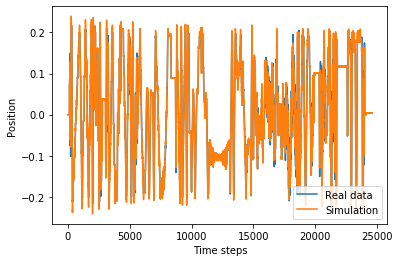

/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/bastian/miniconda3/envs/ml/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


2.1629453


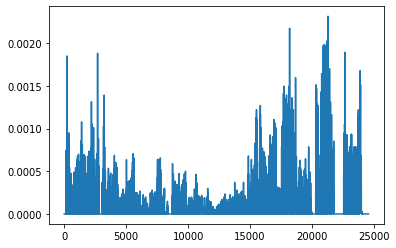

In [45]:
print(pos)
s = fun(pos)

plt.figure()
a, = plt.plot(states[:,0], label='Real data')
b, = plt.plot(s[:,0], label='Simulation')
plt.xlabel('Time steps')
plt.ylabel('Position')
plt.legend(handles=[a,b])
tikzplotlib.save("cartfit.tex")
plt.show()

plt.figure()
plt.plot(loss_(pos))
print(np.sum(loss_(pos)))

In [40]:
pos = [3.35711521, 0.38367182, 19.35720545, 1.49591271, 0]
for i in range(20):
    pos[-1] = i
    print(i, np.mean(loss_(pos, steps=100)))

0 0.014405245
1 0.014163173
2 0.013955775
3 0.013782156
4 0.013639675
5 0.01352463
6 0.0134330075
7 0.013361254
8 0.013306628
9 0.013267354
10 0.01324249
11 0.013231607
12 0.013234395
13 0.013250176
14 0.013277588
15 0.013314582
16 0.013358553
17 0.013406734
18 0.013456626
19 0.013506361


In [21]:
time_delay = 0
best_cost =  17.854625701904297
best_pos = [2.20871964, 0.52280259, 4.37161942, 2.69738758]

time_delay = 2
best_cost = 18.811220169067383
best_pos = [4.33691465, 0.30320143, 9.49224389, 1.99245442]

time_delay = 3
best_cost = 17.915111541748047
best_pos = [4.47010895, 0.13583217, 5.66745458, 2.70516804]

time_delay = 4
best_cost = 18.30472755432129
best_pos = [4.89254444, 0.14797265, 6.14088383, 2.64498657]

time_delay = 5
best_cost = 20.5646915435791
best_pos = [4.88591992, 0.14972133, 13.29892665, 1.80442062]